# Laboratorio 2. Deep Learning
### Modelos de series de tiempo con LSTM 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error

import sys
import os

In [6]:
importacion = pd.read_csv('./data/importacion.csv',index_col='Fecha')
print ('\n Parsed Data:')
importacion.head()


 Parsed Data:


,Gasolina regular,Gasolina superior,Diesel bajo azufre,Diesel ultra bajo azufre,Diesel alto azufre,Mes,Año,Total_mensual
Fecha,,,,,,,,
2001-01-01,177776.50,373963.96,0.0,0.0,566101.99,1.0,2001.0,1117842.45
2001-02-01,123115.99,243091.07,0.0,0.0,489525.80,2.0,2001.0,855732.86
2001-03-01,161726.42,312084.38,0.0,0.0,575559.68,3.0,2001.0,1049370.48
2001-04-01,127338.74,285054.89,0.0,0.0,437745.42,4.0,2001.0,850139.05
2001-05-01,168730.19,300913.67,0.0,0.0,552609.13,5.0,2001.0,1022252.99


      Año  Gasolina regular  Gasolina superior  Diesel alto azufre
0  2001.0         233643.75          373963.96          575559.680
1  2002.0         222408.00          440677.81          703749.810
2  2003.0         269981.86          459025.69          873103.096
3  2004.0         275539.38          486880.82          809194.950
4  2005.0         266018.37          566618.55         1212610.530


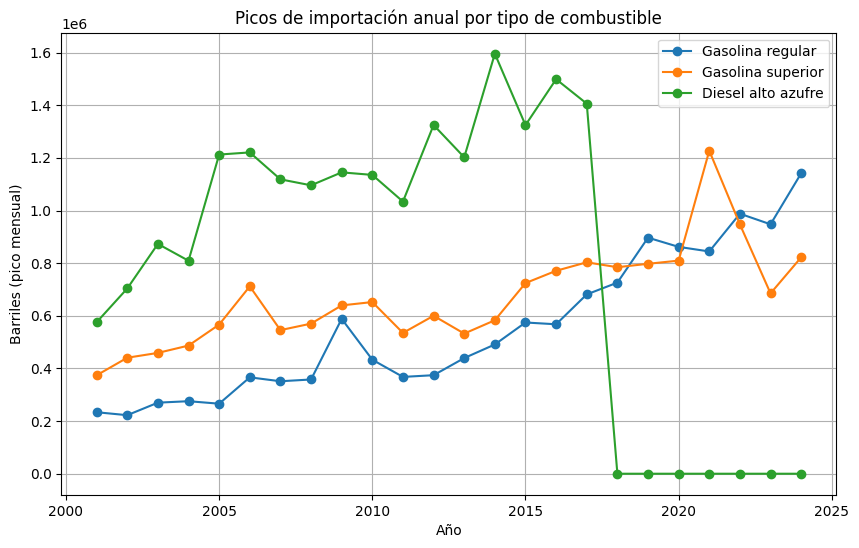

In [12]:
importacion = importacion.sort_index()

#picos en importaciones por anio por tipo de combustibles

columnas_necesarias = [
    "Gasolina regular", "Gasolina superior", 
     "Diesel alto azufre" #"Diesel bajo azufre", "Diesel ultra bajo azufre",
]


for col in columnas_necesarias:
    importacion[col] = pd.to_numeric(importacion[col], errors="coerce")

picos_por_anio = (
    importacion.groupby("Año")[columnas_necesarias]
    .max()  # el pico anual
    .reset_index()
)

print(picos_por_anio.head()) 

plt.figure(figsize=(10,6))
for col in columnas_necesarias:
    plt.plot(picos_por_anio["Año"], picos_por_anio[col], marker='o', label=col)

plt.title("Picos de importación anual por tipo de combustible")
plt.xlabel("Año")
plt.ylabel("Barriles (pico mensual)")
plt.legend()
plt.grid(True)
plt.show()


In [22]:
df = pd.DataFrame(picos_por_anio)
df

,Año,Gasolina regular,Gasolina superior,Diesel alto azufre
0,2001.0,233643.75,373963.96,575559.680
1,2002.0,222408.00,440677.81,703749.810
2,2003.0,269981.86,459025.69,873103.096
3,2004.0,275539.38,486880.82,809194.950
4,2005.0,266018.37,566618.55,1212610.530
5,2006.0,366193.77,711860.77,1220719.640
6,2007.0,351306.27,545587.63,1118432.250
7,2008.0,358036.44,570256.98,1095743.350
8,2009.0,588346.36,639524.61,1144960.660
9,2010.0,433108.23,652210.77,1135293.920


In [28]:
df_gasolina_superior = df[['Año', 'Gasolina superior']]
df_gasolina_superior = df_gasolina_superior.set_index('Año')
df_gasolina_superior

,Gasolina superior
Año,
2001.0,373963.96
2002.0,440677.81
2003.0,459025.69
2004.0,486880.82
2005.0,566618.55
2006.0,711860.77
2007.0,545587.63
2008.0,570256.98
2009.0,639524.61


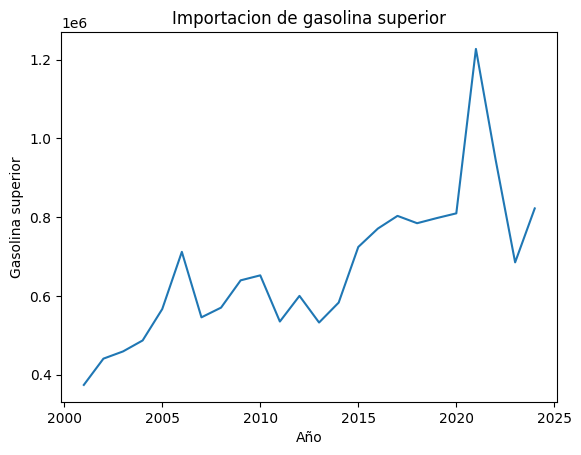

In [33]:
plt.plot(df_gasolina_superior)
plt.gca().set(title="Importacion de gasolina superior", xlabel="Año", ylabel="Gasolina superior")
plt.show()
df = df_gasolina_superior

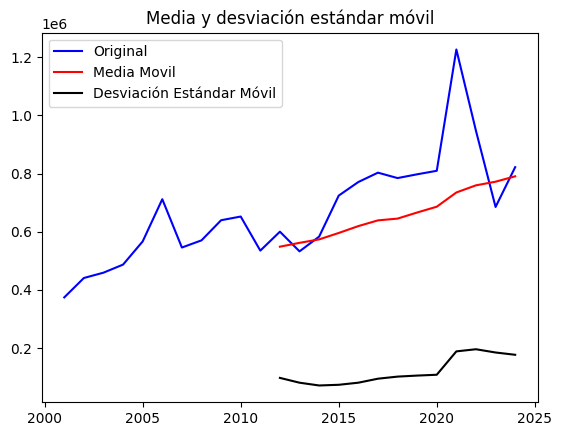

In [34]:
# Se calcula la media móvil y la desviación estandar móvil de los últimos 12 meses.
mediaMovil = df.rolling(window=12).mean()
deMovil = df.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(df, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

In [36]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(df, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba        -2.225794
p-value                       0.197017
# de retardos usados          0.000000
# de observaciones usadas    23.000000
Critical Value (1%)          -3.752928
Critical Value (5%)          -2.998500
Critical Value (10%)         -2.638967
dtype: float64


In [37]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
ts_air_pas_diff = df.diff()
ts_air_pas_diff.fillna(0,inplace=True)
dfTest = adfuller(ts_air_pas_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba        -3.653387
p-value                       0.004819
# de retardos usados          9.000000
# de observaciones usadas    14.000000
Critical Value (1%)          -4.012034
Critical Value (5%)          -3.104184
Critical Value (10%)         -2.690987
dtype: float64


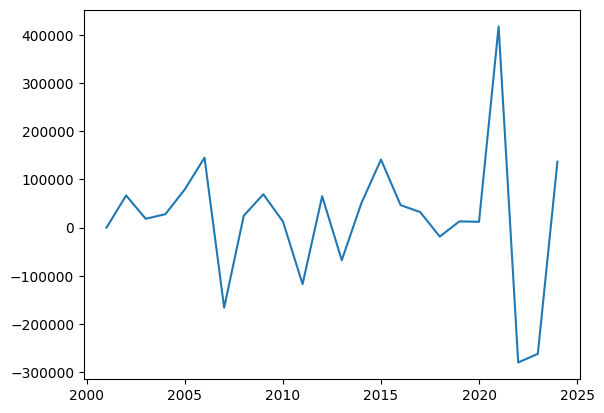

In [38]:
plt.plot(ts_air_pas_diff)

In [39]:
scaler = StandardScaler()
ts_air_pas_scaled = scaler.fit_transform(ts_air_pas_diff) 
ts_air_pas_scaled[1:7]

array([[ 0.35201057],
       [-0.00239843],
       [ 0.06726739],
       [ 0.44744503],
       [ 0.92743913],
       [-1.355237  ]])

In [40]:
total_len = len(ts_air_pas_scaled)

# Definir proporciones
train_prop = 0.6
val_prop = 0.2
test_prop = 0.2 

# Calcular índices
train_end = int(train_prop * total_len)
val_end = train_end + int(val_prop * total_len)

# Separar sin solapamientos
train = ts_air_pas_scaled[:train_end]
validation = ts_air_pas_scaled[train_end:val_end]
test = ts_air_pas_scaled[val_end:]

# Si hace falta, redimensionar (por ejemplo para un LSTM univariante)
train = train.reshape(-1, 1)
validation = validation.reshape(-1, 1)
test = test.reshape(-1, 1)

# Verificar tamaños
print(f"Total registros: {total_len}")
print(f"Train: {len(train)} | Validation: {len(validation)} | Test: {len(test)}")

Total registros: 24
Train: 14 | Validation: 4 | Test: 6


In [41]:
train, type(train)

(array([[-0.1368453 ],
        [ 0.35201057],
        [-0.00239843],
        [ 0.06726739],
        [ 0.44744503],
        [ 0.92743913],
        [-1.355237  ],
        [ 0.04392311],
        [ 0.37072378],
        [-0.04388554],
        [-0.99627196],
        [ 0.34068803],
        [-0.63303264],
        [ 0.23468064]]),
 numpy.ndarray)

In [43]:
from operator import concat


def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

x_train,y_train = supervisada(train)
x_val,y_val = supervisada(validation)
x_test,y_test = supervisada(test)

x_train

array([[-0.1368453 ],
       [ 0.35201057],
       [-0.00239843],
       [ 0.06726739],
       [ 0.44744503],
       [ 0.92743913],
       [-1.355237  ],
       [ 0.04392311],
       [ 0.37072378],
       [-0.04388554],
       [-0.99627196],
       [ 0.34068803],
       [-0.63303264]])

## Creacion del modelo 

#### Modelo 1 

In [45]:
(x_train.shape[0],1,1)
x_train = np.reshape(x_train,(x_train.shape[0],1,1))
x_val = np.reshape(x_val, (x_val.shape[0],1,1))
x_test = np.reshape(x_test, (x_test.shape[0],1,1))
len(x_val)

3

In [46]:
unidades =  10
paso = 1 # lags, 1 lag es un mes. 
caracteristicas = 1 # es univariada
lote = 1


modelo1 = Sequential()
modelo1.add(LSTM(
    units=unidades, 
    input_shape=(paso, caracteristicas), 
    stateful=False  # desactivamos estado entre batches
))

# modelo1.add(LSTM(
#     units=unidades, 
#     batch_input_shape=(lote, paso, caracteristicas), 
#     stateful=True  # activamos estado entre batches
# ))
modelo1.add(Dense(1))
modelo1.summary()

c:\Users\Francis\OneDrive - UVG\Francis\2025\Semestre 8\Data Science\lab2-ds\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491 (1.92 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
modelo1.compile(loss='mean_squared_error',optimizer="rmsprop")

In [48]:
epocas = 50
history= modelo1.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.2988 - val_loss: 0.0421
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2959 - val_loss: 0.0425
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2953 - val_loss: 0.0429
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2948 - val_loss: 0.0433
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2943 - val_loss: 0.0437
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2938 - val_loss: 0.0441
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2934 - val_loss: 0.0445
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2929 - val_loss: 0.0449
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2925 - val_loss: 0.0453
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2921 - val_loss: 0.0457
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2917 - val_loss: 0.0461
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2

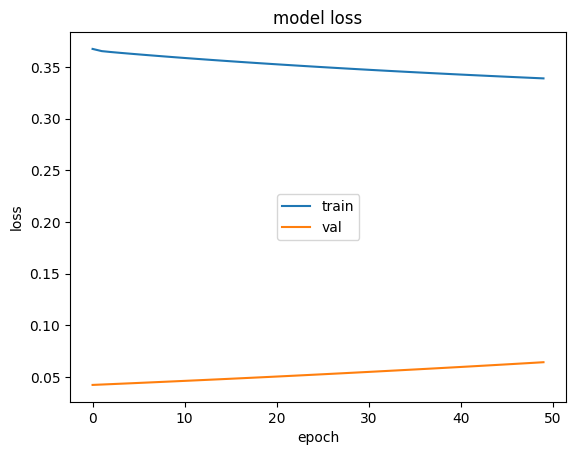

In [49]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

#### Modelo 2

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


unidades = 10
paso = 1
caracteristicas = 1

modelo2 = Sequential()
modelo2.add(LSTM(
    units=unidades,
    return_sequences=True,  # importante para encadenar otra LSTM
    input_shape=(paso, caracteristicas),
    stateful=False
))
modelo2.add(Dropout(0.2))  # regularización

modelo2.add(LSTM(
    units=unidades,
    return_sequences=False  # ahora sí, no se necesita devolver secuencia
))
modelo2.add(Dropout(0.2))

modelo2.add(Dense(1))  # salida univariada

modelo2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 1, 10)          │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 10)             │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,331 (5.20 KB)

 Trainable params: 1,331 (5.20 KB)

 Non-trainable params: 0 (0.00 B)